In [38]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [39]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.01

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,n-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)
# test_phantom.add_tissue_sphere((-pos,2*pos,0), 6, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


(70, 50, 50)
(50, 70, 50)


514


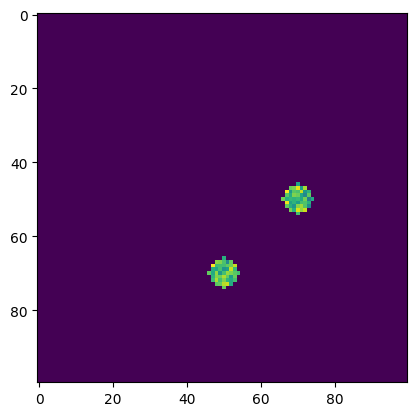

In [40]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [41]:
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 96, 
#                                     width = 40e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 64, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 50e-3,
#                                     ) for i in range(1)]

transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 64, 
                                    width = 30e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = 0,
                                    ray_num = 1, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

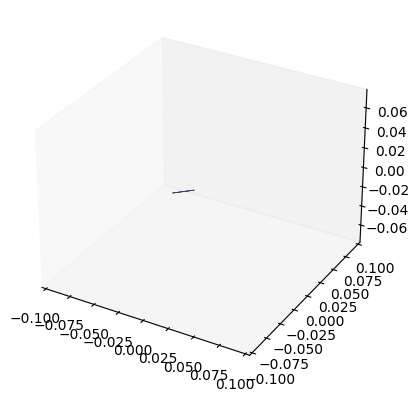

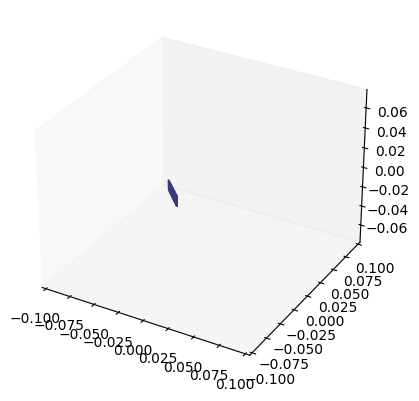

In [42]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
#test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 1e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/20,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

test_transducer_set.assign_pose(0, geometry.Transform([np.pi/4,0,0], [-0.02,-0.02,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.02, 0,0]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [43]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


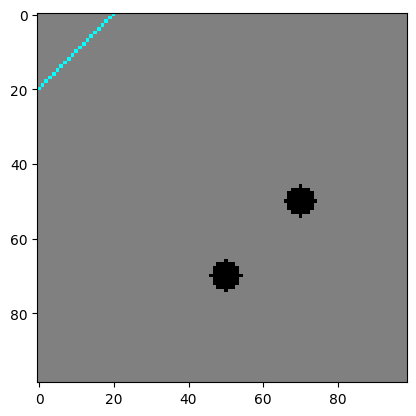

In [44]:
gm = test_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

In [45]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [46]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_03',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

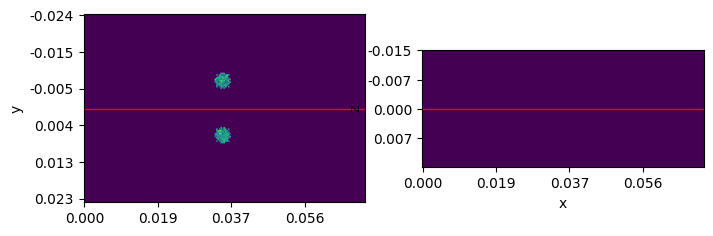

In [47]:
test_experiment.plot_ray_path(0)

In [48]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_03')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (1), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


In [49]:
test_experiment.run(repeat=True)

running with 1 workers

preparation for sim    0 completed in            2.22 seconds



simulation      0 completed in  4.46 seconds


In [50]:
test_experiment.add_results()

In [51]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [52]:
image_matrices = test_reconstruction.compound(workers=16, resolution_multiplier=4, local=True)

100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]


In [55]:
image = np.sum(image_matrices, axis=0)

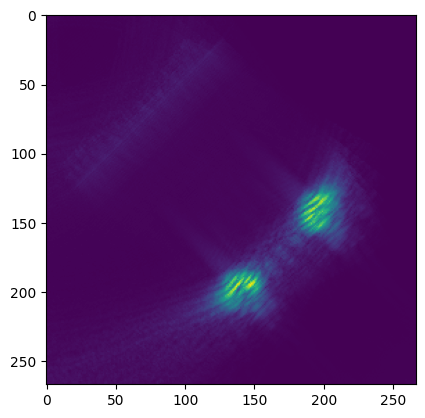

In [36]:
plt.imshow(image[:,:,image.shape[2]//2])

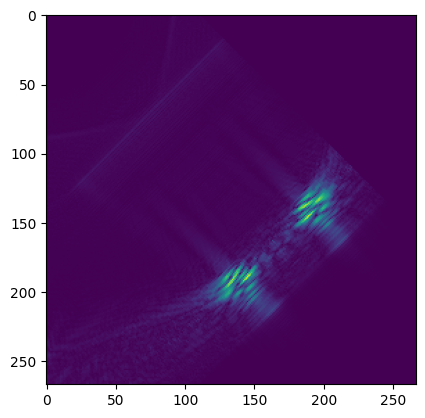

In [56]:
plt.imshow(image[:,:,image.shape[2]//2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


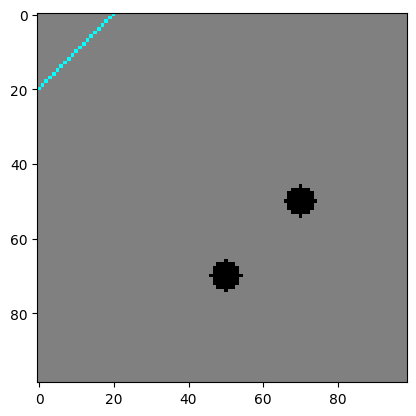

In [37]:
gm = test_experiment.sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])